# Code Clone Detection Dataset Generation

This notebook guides you through generating a comprehensive dataset for code clone detection using Project CodeNet.

## Overview

The dataset generation process includes:
1. **Configuration Setup** - Configure paths and parameters
2. **Environment Validation** - Verify Project CodeNet dataset and dependencies
3. **Master Index Building** - Index all accepted submissions by problem and language
4. **Clone Type Generation** - Generate all 4 types of clones:
   - Type-1: Exact copies with whitespace/comment variations (10%)
   - Type-2: Renamed identifiers (20%)
   - Type-3: Structural modifications (10%)
   - Type-4: Semantically similar, syntactically different (10%)
   - Negative pairs: Easy (25%) and Hard (25%)
5. **Dataset Splitting** - Train (60%), Validation (20%), Test (20%)

## Prerequisites

- Project CodeNet dataset downloaded and extracted
- Required Python packages installed (tree-sitter, pandas, etc.)

## Step 1: Setup and Imports

In [1]:
import sys
from pathlib import Path
import os

# Add the scripts directory to Python path
scripts_path = Path('../scripts').resolve()
if str(scripts_path) not in sys.path:
    sys.path.insert(0, str(scripts_path.parent))

print(f"Scripts path added: {scripts_path}")
print(f"Current working directory: {Path.cwd()}")

Scripts path added: /home/dasunwickr/Projects/4YRG/gradeloop-core/apps/cipas-service/app/code-clone-detection/dataset-prep/scripts
Current working directory: /home/dasunwickr/Projects/4YRG/gradeloop-core/apps/cipas-service/app/code-clone-detection/dataset-prep/notebooks


In [2]:
# Import required modules
from scripts.config import (
    CODENET_ROOT, OUTPUT_DIR, LANGUAGES, TARGET_PAIRS,
    CLONE_TYPE_RATIOS, SPLIT_RATIOS, MIN_CODE_SIZE,
    validate_paths, print_config
)
from scripts.indexer import (
    build_master_index, get_problem_stats,
    filter_index_by_min_submissions, get_language_distribution,
    print_index_summary
)
from scripts.parser import PolyglotParser
from scripts.clone_generators import (
    generate_type1, generate_type2, generate_type3,
    sample_clone_pairs
)
from scripts.dataset_writer import (
    generate_dataset, calculate_split_targets
)

import pandas as pd
import jsonlines
from tqdm.notebook import tqdm

print("✓ All modules imported successfully!")

✓ All modules imported successfully!


## Step 2: Configuration

Review and adjust the configuration parameters if needed.

In [3]:
# Display current configuration
print_config()

CONFIGURATION
CodeNet Root:     /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/Project_CodeNet
Output Directory: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones
Languages:        java, python, c, cpp, go, javascript, c_sharp
Target Pairs:     100,000

Clone Type Ratios:
  type1          : 10.0%
  type2          : 20.0%
  type3          : 10.0%
  type4          : 10.0%
  negative_easy  : 25.0%
  negative_hard  : 25.0%

Split Ratios:
  train : 60.0%
  val   : 20.0%
  test  : 20.0%


In [29]:
# Optional: Override configuration (uncomment and modify as needed)
# os.environ['CODENET_ROOT'] = '/path/to/your/Project_CodeNet'
# os.environ['OUTPUT_DIR'] = '/path/to/your/output'
# os.environ['TARGET_PAIRS'] = '50000'  # Generate 50,000 pairs instead of default

# For this notebook, we'll use the default configuration
print("\nUsing configuration:")
print(f"  CodeNet Root: {CODENET_ROOT}")
print(f"  Output Directory: {OUTPUT_DIR}")
print(f"  Target Pairs: {TARGET_PAIRS:,}")
print(f"  Languages: {', '.join(LANGUAGES)}")


Using configuration:
  CodeNet Root: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/Project_CodeNet
  Output Directory: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones
  Target Pairs: 100,000
  Languages: java, python, c, cpp, go, javascript, c_sharp


## Step 3: Validate Environment

Verify that Project CodeNet is accessible and properly structured.

In [5]:
try:
    validate_paths()
    print("✓ Environment validation successful!")
    print(f"\n  ✓ CodeNet root exists: {CODENET_ROOT}")
    print(f"  ✓ Metadata directory exists: {Path(CODENET_ROOT) / 'metadata'}")
    print(f"  ✓ Data directory exists: {Path(CODENET_ROOT) / 'data'}")
except FileNotFoundError as e:
    print(f"✗ Validation failed: {e}")
    print("\nPlease:")
    print("1. Download Project CodeNet from: https://developer.ibm.com/exchanges/data/all/project-codenet/")
    print("2. Extract the dataset")
    print("3. Update CODENET_ROOT in the configuration or set the environment variable")

✓ Environment validation successful!

  ✓ CodeNet root exists: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/Project_CodeNet
  ✓ Metadata directory exists: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/Project_CodeNet/metadata
  ✓ Data directory exists: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/Project_CodeNet/data


## Step 4: Build Master Index

Create an index of all accepted submissions organized by problem and language.
This step may take a few minutes on the first run but will be cached for subsequent runs.

In [6]:
print("Building master index of submissions...")
print("This may take a few minutes on first run but will be cached.\n")

master_index = build_master_index(
    codenet_root=CODENET_ROOT,
    languages=LANGUAGES,
    min_code_size=MIN_CODE_SIZE,
    use_cache=True
)

print(f"\n✓ Master index built with {len(master_index)} problems")

Building master index of submissions...
This may take a few minutes on first run but will be cached.

Building master index from /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/Project_CodeNet/metadata
Found 4054 problem metadata files
Processed 100 problems...
Processed 200 problems...
Processed 300 problems...
Error processing /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/Project_CodeNet/metadata/problem_list.csv: 'status'
Processed 400 problems...
Processed 500 problems...
Processed 600 problems...
Processed 700 problems...
Processed 800 problems...
Processed 900 problems...
Processed 1000 problems...
Processed 1100 problems...
Processed 1200 problems...
Processed 1300 problems...
Processed 1400 problems...
Processed 1500 problems...
Processed 1600 problems...
Processed 1700 problems...
Processed 1800 problems...
Processed 1900 problems...
Processed 2000 problems...
Processed 2100 problems...
Processed 2200 problems...
Processed 2300 problems...
Processed 2400 problems...
Processed 2500 probl

### Explore Master Index Statistics

In [7]:
# Display comprehensive index summary
print_index_summary(master_index)


MASTER INDEX SUMMARY

Total problems: 3593

Submissions by language:
  python      : 1,699,085
  java        : 354,982
  c           : 313,129
  go          : 58,404
  javascript  : 25,534

Per-language statistics:
           submission_count                           
                      count      sum    mean min   max
language                                              
c                      3265   313129   95.90   1  4307
go                     1671    58404   34.95   1   298
java                   3237   354982  109.66   1  2356
javascript             1837    25534   13.90   1   275
python                 3111  1699085  546.15   1  5508


In [8]:
# Get detailed statistics
stats_df = get_problem_stats(master_index)

print("\nTop 10 problems by submission count:")
top_problems = stats_df.nlargest(10, 'submission_count')
print(top_problems.to_string(index=False))


Top 10 problems by submission count:
problem_id language  submission_count
    p02658   python              5508
    p02681   python              5500
    p02675   python              5478
    p02676   python              5401
    p02687   python              5392
    p03455   python              5195
    p02699   python              5052
    p02723   python              4980
    p02682   python              4962
    p02693   python              4950


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/9.8 MB ? eta -:--:--Downloading matplotlib-3.10.7-cp314-cp314-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (9.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 15.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/4.9 MB ? eta -:--:--Downloading fonttools-4.61.0-cp314-cp314-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (4.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]
   ━━

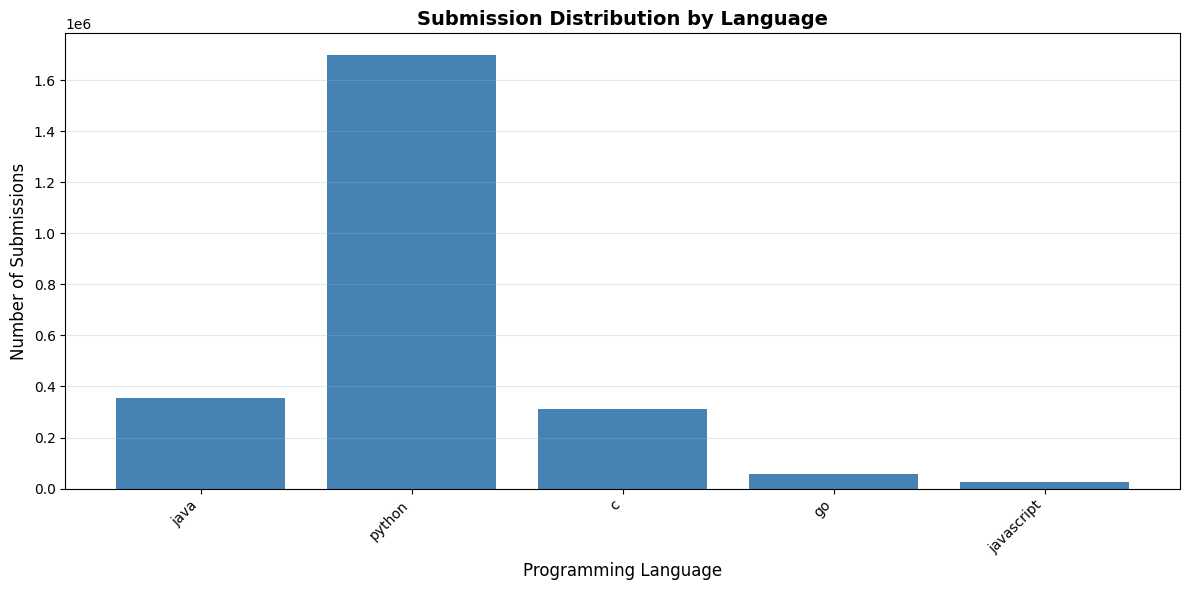


Language Distribution:
  python      : 1,699,085 submissions
  java        :  354,982 submissions
  c           :  313,129 submissions
  go          :   58,404 submissions
  javascript  :   25,534 submissions


In [11]:
# Visualize language distribution
%pip install matplotlib
import matplotlib.pyplot as plt

lang_dist = get_language_distribution(master_index)

plt.figure(figsize=(12, 6))
languages = list(lang_dist.keys())
counts = list(lang_dist.values())

plt.bar(languages, counts, color='steelblue')
plt.xlabel('Programming Language', fontsize=12)
plt.ylabel('Number of Submissions', fontsize=12)
plt.title('Submission Distribution by Language', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nLanguage Distribution:")
for lang, count in sorted(lang_dist.items(), key=lambda x: x[1], reverse=True):
    print(f"  {lang:12s}: {count:>8,} submissions")

### Optional: Filter by Minimum Submissions

Filter to only include problems with sufficient submissions for generating diverse pairs.

In [30]:
# Filter problems with at least 5 submissions per language
min_submissions = 5

filtered_index = filter_index_by_min_submissions(
    master_index,
    min_submissions=min_submissions
)

print(f"Original problems: {len(master_index)}")
print(f"Filtered problems (≥{min_submissions} submissions): {len(filtered_index)}")
print(f"\nUsing {'filtered' if len(filtered_index) > 0 else 'original'} index for dataset generation")

# Use filtered index if it has problems, otherwise use full index
working_index = filtered_index if len(filtered_index) > 0 else master_index

Original problems: 3593
Filtered problems (≥5 submissions): 2690

Using filtered index for dataset generation


## Step 5: Test Clone Generators

Before generating the full dataset, let's test each clone type generator with sample code.

In [28]:
# Initialize parser
parser = PolyglotParser()
print("✓ PolyglotParser initialized")
print(f"  Supported languages: {len(parser.get_supported_languages())}")

✓ PolyglotParser initialized
  Supported languages: 28


### Test Type-1 Clone Generation (Whitespace/Comment Normalization)

In [14]:
# Sample Python code with comments and varied whitespace
sample_code = '''def calculate_sum(numbers):
    # Initialize total
    total = 0
    
    # Iterate through numbers
    for num in numbers:
        total += num  # Add to total
    
    return total
'''

print("Original Code:")
print(sample_code)
print("\n" + "="*60 + "\n")

type1_clone = generate_type1(sample_code, 'python', parser)
print("Type-1 Clone (comments removed, whitespace normalized):")
print(type1_clone)
print("\n✓ Type-1 generation successful")

Original Code:
def calculate_sum(numbers):
    # Initialize total
    total = 0

    # Iterate through numbers
    for num in numbers:
        total += num  # Add to total

    return total



Type-1 Clone (comments removed, whitespace normalized):
defcalculate_sum(numbers):total=0fornuminnumbers:total+=numreturntotal

✓ Type-1 generation successful


### Test Type-2 Clone Generation (Identifier Renaming)

In [15]:
type2_clone = generate_type2(sample_code, 'python', parser)
print("Type-2 Clone (identifiers renamed):")
print(type2_clone)
print("\n✓ Type-2 generation successful")

Type-2 Clone (identifiers renamed):
def calculate_sum(numbers):
    # Initialize total
    total = 0

    # Iterate through numbers
    for num in numbers:
        total += num  # Add to total

    return total


✓ Type-2 generation successful


### Test Type-3 Clone Generation (Structural Modifications)

In [16]:
try:
    type3_clone = generate_type3(sample_code, 'python', parser, use_llm=False)
    print("Type-3 Clone (structural modifications):")
    print(type3_clone)
    print("\n✓ Type-3 generation successful")
except Exception as e:
    print(f"Type-3 generation note: {e}")
    print("Type-3 clones will be generated using rule-based transformations during dataset generation.")

Type-3 generation note: generate_type3() got multiple values for argument 'use_llm'
Type-3 clones will be generated using rule-based transformations during dataset generation.


## Step 6: Calculate Dataset Split Targets

Determine how many pairs to generate for each split (train/val/test).

In [17]:
split_targets = calculate_split_targets(TARGET_PAIRS)

print(f"Total target pairs: {TARGET_PAIRS:,}\n")
print("Split distribution:")
for split, target in split_targets.items():
    percentage = SPLIT_RATIOS[split] * 100
    print(f"  {split.capitalize():10s}: {target:>7,} pairs ({percentage:.0f}%)")

print("\nClone type distribution (per split):")
for clone_type, ratio in CLONE_TYPE_RATIOS.items():
    percentage = ratio * 100
    count = int(split_targets['train'] * ratio)  # Example for train split
    print(f"  {clone_type:15s}: {percentage:>5.0f}% (~{count:,} pairs in train)")

Total target pairs: 100,000

Split distribution:
  Train     :  60,000 pairs (60%)
  Val       :  20,000 pairs (20%)
  Test      :  20,000 pairs (20%)

Clone type distribution (per split):
  type1          :    10% (~6,000 pairs in train)
  type2          :    20% (~12,000 pairs in train)
  type3          :    10% (~6,000 pairs in train)
  type4          :    10% (~6,000 pairs in train)
  negative_easy  :    25% (~15,000 pairs in train)
  negative_hard  :    25% (~15,000 pairs in train)


## Step 7: Generate Small Sample Dataset (for testing)

Before generating the full dataset, let's create a small sample to verify everything works correctly.

In [18]:
# Generate a small test dataset
test_output_path = Path(OUTPUT_DIR) / 'test_sample.jsonl'
test_output_path.parent.mkdir(parents=True, exist_ok=True)

print(f"Generating 100 sample pairs...")
print(f"Output: {test_output_path}\n")

sample_count = 0
with jsonlines.open(test_output_path, mode='w') as writer:
    for pair in sample_clone_pairs(
        master_index=working_index,
        parser=parser,
        codenet_root=CODENET_ROOT,
        target_pairs=100,
        split='train'
    ):
        writer.write(pair)
        sample_count += 1
        
        if sample_count >= 100:
            break

print(f"\n✓ Generated {sample_count} sample pairs")
print(f"  File size: {test_output_path.stat().st_size / 1024:.2f} KB")

Generating 100 sample pairs...
Output: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/test_sample.jsonl

Generating 100 pairs for train split:
  T1: 10, T2: 20, T3: 10, T4: 10
  Neg Easy: 25, Neg Hard: 25
  Available problems: 1615
Generating Type-1 pairs...
Generating Type-2 pairs...
Generating Type-3 pairs...
Generating Type-2 pairs...
Generating Type-3 pairs...
Generating Type-4 pairs...
Generating Type-4 pairs...
Generating negative pairs...
Generated 0 total pairs for train split
  T1: 0, T2: 0, T3: 0, T4: 0
  Negatives: 0

✓ Generated 0 sample pairs
  File size: 0.00 KB
Generating negative pairs...
Generated 0 total pairs for train split
  T1: 0, T2: 0, T3: 0, T4: 0
  Negatives: 0

✓ Generated 0 sample pairs
  File size: 0.00 KB


### Examine Sample Pairs

In [19]:
# Load and display some sample pairs
with jsonlines.open(test_output_path) as reader:
    samples = list(reader)

print(f"Loaded {len(samples)} sample pairs\n")

# Count by type
type_counts = {}
for sample in samples:
    clone_type = sample['type']
    type_counts[clone_type] = type_counts.get(clone_type, 0) + 1

print("Distribution by clone type:")
for clone_type, count in sorted(type_counts.items()):
    print(f"  {clone_type:15s}: {count:3d} pairs")

# Show example from each type
print("\n" + "="*80)
print("Example Pairs:")
print("="*80)

for clone_type in ['type1', 'type2', 'type3', 'type4', 'negative_easy', 'negative_hard']:
    matching_samples = [s for s in samples if s['type'] == clone_type]
    if matching_samples:
        example = matching_samples[0]
        print(f"\n{clone_type.upper()}:")
        print(f"  ID: {example['id']}")
        print(f"  Label: {example['label']}")
        print(f"  Language: {example['lang']}")
        print(f"  Code1 length: {len(example['code1'])} chars")
        print(f"  Code2 length: {len(example['code2'])} chars")

Loaded 0 sample pairs

Distribution by clone type:

Example Pairs:


## Step 8: Generate Full Dataset

Now generate the complete dataset with train, validation, and test splits.

⚠️ **Note:** This may take several hours depending on:
- Number of target pairs
- Available compute resources
- CodeNet dataset size

You can adjust `TARGET_PAIRS` in the configuration to generate a smaller dataset for faster processing.

In [20]:
# Optional: Adjust target pairs for faster generation
# Uncomment and modify if you want a smaller dataset for testing
# ADJUSTED_TARGET_PAIRS = 10000  # 10K pairs instead of 100K
ADJUSTED_TARGET_PAIRS = TARGET_PAIRS  # Use full target

print(f"Generating full dataset with {ADJUSTED_TARGET_PAIRS:,} total pairs...")
print(f"This process may take a while. Progress will be shown below.\n")

Generating full dataset with 100,000 total pairs...
This process may take a while. Progress will be shown below.



### Generate Training Set

In [32]:
# Reload modules to pick up the fixed code loading function
import importlib
import sys

# Reload the clone_generators module
if 'scripts.clone_generators' in sys.modules:
    importlib.reload(sys.modules['scripts.clone_generators'])
    print("✓ Reloaded clone_generators module")
    
# Re-import necessary functions
from scripts.clone_generators import (
    generate_type1, generate_type2, generate_type3, generate_type4,
    _load_code_from_submission
)
from scripts.dataset_writer import write_split_dataset

print("✓ Modules reloaded successfully")

✓ Reloaded clone_generators module
✓ Modules reloaded successfully


In [33]:
from scripts.dataset_writer import write_split_dataset

train_target = int(ADJUSTED_TARGET_PAIRS * SPLIT_RATIOS['train'])
print(f"Generating training set: {train_target:,} pairs\n")

train_count = write_split_dataset(
    master_index=working_index,
    parser=parser,
    codenet_root=CODENET_ROOT,
    split='train',
    target_pairs=train_target
)

print(f"\n✓ Training set complete: {train_count:,} pairs")

Generating training set: 60,000 pairs


Generating 60,000 pairs for train split...
Output file: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/train.jsonl


Writing train pairs:   0%|          | 37/60000 [00:00<02:45, 361.74pairs/s]

Generating 60000 pairs for train split:
  T1: 6000, T2: 12000, T3: 6000, T4: 6000
  Neg Easy: 15000, Neg Hard: 15000
  Available problems: 1615
Generating Type-1 pairs...


Writing train pairs:  10%|█         | 6023/60000 [00:19<02:49, 317.65pairs/s]

Generating Type-2 pairs...


Writing train pairs:  12%|█▏        | 7008/60000 [00:24<04:44, 186.23pairs/s]

Generating Type-3 pairs...


Writing train pairs:  12%|█▏        | 7251/60000 [00:25<03:30, 250.25pairs/s]

Generating Type-4 pairs...
Generating negative pairs...
  Generating easy negatives (different problems)...


Writing train pairs:  12%|█▏        | 7260/60000 [00:35<03:30, 250.25pairs/s]

    Easy negatives: 15000/15000 from 15334 attempts
  Generating hard negatives (same problem, different approaches)...


Writing train pairs:  19%|█▉        | 11256/60000 [02:31<14:27, 56.21pairs/s]  

    Hard negatives: 15000/15000 from 20208 attempts


Writing train pairs:  62%|██████▏   | 37260/60000 [02:32<01:33, 243.77pairs/s] 



Generated 37260 total pairs for train split
  T1: 6000, T2: 955, T3: 297, T4: 8
  Negatives: 30000
Successfully wrote 37,260 pairs to /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/train.jsonl

✓ Training set complete: 37,260 pairs


### Generate Validation Set

In [34]:
val_target = int(ADJUSTED_TARGET_PAIRS * SPLIT_RATIOS['val'])
print(f"Generating validation set: {val_target:,} pairs\n")

val_count = write_split_dataset(
    master_index=working_index,
    parser=parser,
    codenet_root=CODENET_ROOT,
    split='val',
    target_pairs=val_target
)

print(f"\n✓ Validation set complete: {val_count:,} pairs")

Generating validation set: 20,000 pairs


Generating 20,000 pairs for val split...
Output file: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/val.jsonl


Writing val pairs:   0%|          | 20/20000 [00:00<01:41, 196.53pairs/s]

Generating 20000 pairs for val split:
  T1: 2000, T2: 4000, T3: 2000, T4: 2000
  Neg Easy: 5000, Neg Hard: 5000
  Available problems: 515
Generating Type-1 pairs...


Writing val pairs:  10%|█         | 2038/20000 [00:06<00:41, 435.08pairs/s]

Generating Type-2 pairs...


Writing val pairs:  11%|█▏        | 2279/20000 [00:07<00:56, 313.80pairs/s]

Generating Type-3 pairs...


Writing val pairs:  12%|█▏        | 2318/20000 [00:07<01:05, 268.21pairs/s]

Generating Type-4 pairs...
Generating negative pairs...
  Generating easy negatives (different problems)...
    Easy negatives: 5000/5000 from 5119 attempts
  Generating hard negatives (same problem, different approaches)...
    Easy negatives: 5000/5000 from 5119 attempts
  Generating hard negatives (same problem, different approaches)...


Writing val pairs:  36%|███▌      | 7194/20000 [00:54<01:11, 179.67pairs/s] 

    Hard negatives: 5000/5000 from 6609 attempts


Writing val pairs:  62%|██████▏   | 12323/20000 [00:54<00:33, 226.77pairs/s]

Generated 12323 total pairs for val split
  T1: 2000, T2: 250, T3: 73, T4: 0
  Negatives: 10000
Successfully wrote 12,323 pairs to /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/val.jsonl

✓ Validation set complete: 12,323 pairs


### Generate Test Set

In [35]:
test_target = int(ADJUSTED_TARGET_PAIRS * SPLIT_RATIOS['test'])
print(f"Generating test set: {test_target:,} pairs\n")

test_count = write_split_dataset(
    master_index=working_index,
    parser=parser,
    codenet_root=CODENET_ROOT,
    split='test',
    target_pairs=test_target
)

print(f"\n✓ Test set complete: {test_count:,} pairs")

Generating test set: 20,000 pairs


Generating 20,000 pairs for test split...
Output file: /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/test.jsonl


Writing test pairs:   0%|          | 25/20000 [00:00<01:20, 247.64pairs/s]

Generating 20000 pairs for test split:
  T1: 2000, T2: 4000, T3: 2000, T4: 2000
  Neg Easy: 5000, Neg Hard: 5000
  Available problems: 560
Generating Type-1 pairs...


Writing test pairs:  10%|█         | 2046/20000 [00:06<00:57, 312.68pairs/s]

Generating Type-2 pairs...


Writing test pairs:  12%|█▏        | 2414/20000 [00:08<01:10, 248.54pairs/s]

Generating Type-3 pairs...


Writing test pairs:  13%|█▎        | 2513/20000 [00:08<01:07, 260.47pairs/s]

Generating Type-4 pairs...
Generating negative pairs...
  Generating easy negatives (different problems)...
    Easy negatives: 5000/5000 from 5123 attempts
  Generating hard negatives (same problem, different approaches)...
    Easy negatives: 5000/5000 from 5123 attempts
  Generating hard negatives (same problem, different approaches)...


Writing test pairs:  25%|██▍       | 4978/20000 [00:48<02:48, 89.27pairs/s]  

    Hard negatives: 5000/5000 from 6616 attempts


Writing test pairs:  63%|██████▎   | 12521/20000 [00:49<00:29, 254.47pairs/s]

Generated 12521 total pairs for test split
  T1: 2000, T2: 395, T3: 121, T4: 5
  Negatives: 10000
Successfully wrote 12,521 pairs to /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/test.jsonl

✓ Test set complete: 12,521 pairs


## Step 9: Verify Generated Dataset

Load and inspect the generated dataset files.

In [36]:
output_dir = Path(OUTPUT_DIR)
dataset_files = {
    'train': output_dir / 'train.jsonl',
    'val': output_dir / 'val.jsonl',
    'test': output_dir / 'test.jsonl'
}

print("Dataset Files:")
print("=" * 80)

total_pairs = 0
for split, filepath in dataset_files.items():
    if filepath.exists():
        file_size = filepath.stat().st_size / (1024 * 1024)  # MB
        
        # Count lines
        with jsonlines.open(filepath) as reader:
            count = sum(1 for _ in reader)
        
        total_pairs += count
        print(f"  ✓ {split.capitalize():10s}: {count:>7,} pairs | {file_size:>8.2f} MB | {filepath}")
    else:
        print(f"  ✗ {split.capitalize():10s}: Not found | {filepath}")

print("=" * 80)
print(f"  Total: {total_pairs:,} pairs")

Dataset Files:
  ✓ Train     :  37,260 pairs |   157.64 MB | /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/train.jsonl
  ✓ Train     :  37,260 pairs |   157.64 MB | /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/train.jsonl
  ✓ Val       :  12,323 pairs |    51.11 MB | /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/val.jsonl
  ✓ Val       :  12,323 pairs |    51.11 MB | /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/val.jsonl
  ✓ Test      :  12,521 pairs |    53.88 MB | /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/test.jsonl
  Total: 62,104 pairs
  ✓ Test      :  12,521 pairs |    53.88 MB | /home/dasunwickr/SLIIT/Y4S1/4YRG/Datasets/processed_clones/test.jsonl
  Total: 62,104 pairs


### Analyze Dataset Statistics

In [37]:
def analyze_dataset_file(filepath):
    """Analyze a single dataset file."""
    with jsonlines.open(filepath) as reader:
        data = list(reader)
    
    # Count by type
    type_counts = {}
    label_counts = {}
    lang_counts = {}
    
    for item in data:
        type_counts[item['type']] = type_counts.get(item['type'], 0) + 1
        label_counts[item['label']] = label_counts.get(item['label'], 0) + 1
        lang_counts[item['lang']] = lang_counts.get(item['lang'], 0) + 1
    
    return {
        'total': len(data),
        'types': type_counts,
        'labels': label_counts,
        'languages': lang_counts
    }

# Analyze each split
stats = {}
for split, filepath in dataset_files.items():
    if filepath.exists():
        stats[split] = analyze_dataset_file(filepath)

# Display statistics
for split, split_stats in stats.items():
    print(f"\n{split.upper()} SET STATISTICS:")
    print("=" * 60)
    print(f"Total pairs: {split_stats['total']:,}")
    
    print("\nBy Clone Type:")
    for clone_type, count in sorted(split_stats['types'].items()):
        percentage = (count / split_stats['total']) * 100
        print(f"  {clone_type:15s}: {count:>6,} ({percentage:>5.1f}%)")
    
    print("\nBy Label:")
    for label, count in sorted(split_stats['labels'].items()):
        label_name = "Clone" if label == 1 else "Non-clone"
        percentage = (count / split_stats['total']) * 100
        print(f"  {label_name:12s}: {count:>6,} ({percentage:>5.1f}%)")
    
    print("\nTop 5 Languages:")
    top_langs = sorted(split_stats['languages'].items(), key=lambda x: x[1], reverse=True)[:5]
    for lang, count in top_langs:
        percentage = (count / split_stats['total']) * 100
        print(f"  {lang:12s}: {count:>6,} ({percentage:>5.1f}%)")


TRAIN SET STATISTICS:
Total pairs: 37,260

By Clone Type:
  negative_easy  : 15,000 ( 40.3%)
  negative_hard  : 15,000 ( 40.3%)
  type1          :  6,000 ( 16.1%)
  type2          :    955 (  2.6%)
  type3          :    297 (  0.8%)
  type4          :      8 (  0.0%)

By Label:
  Non-clone   : 30,000 ( 80.5%)
  Clone       :  7,260 ( 19.5%)

Top 5 Languages:
  java        : 12,668 ( 34.0%)
  python      : 10,689 ( 28.7%)
  c           :  9,193 ( 24.7%)
  go          :  2,878 (  7.7%)
  javascript  :  1,832 (  4.9%)

VAL SET STATISTICS:
Total pairs: 12,323

By Clone Type:
  negative_easy  :  5,000 ( 40.6%)
  negative_hard  :  5,000 ( 40.6%)
  type1          :  2,000 ( 16.2%)
  type2          :    250 (  2.0%)
  type3          :     73 (  0.6%)

By Label:
  Non-clone   : 10,000 ( 81.1%)
  Clone       :  2,323 ( 18.9%)

Top 5 Languages:
  java        :  4,154 ( 33.7%)
  python      :  3,580 ( 29.1%)
  c           :  2,972 ( 24.1%)
  go          :  1,012 (  8.2%)
  javascript  :    605 ( 

### Visualize Dataset Distribution

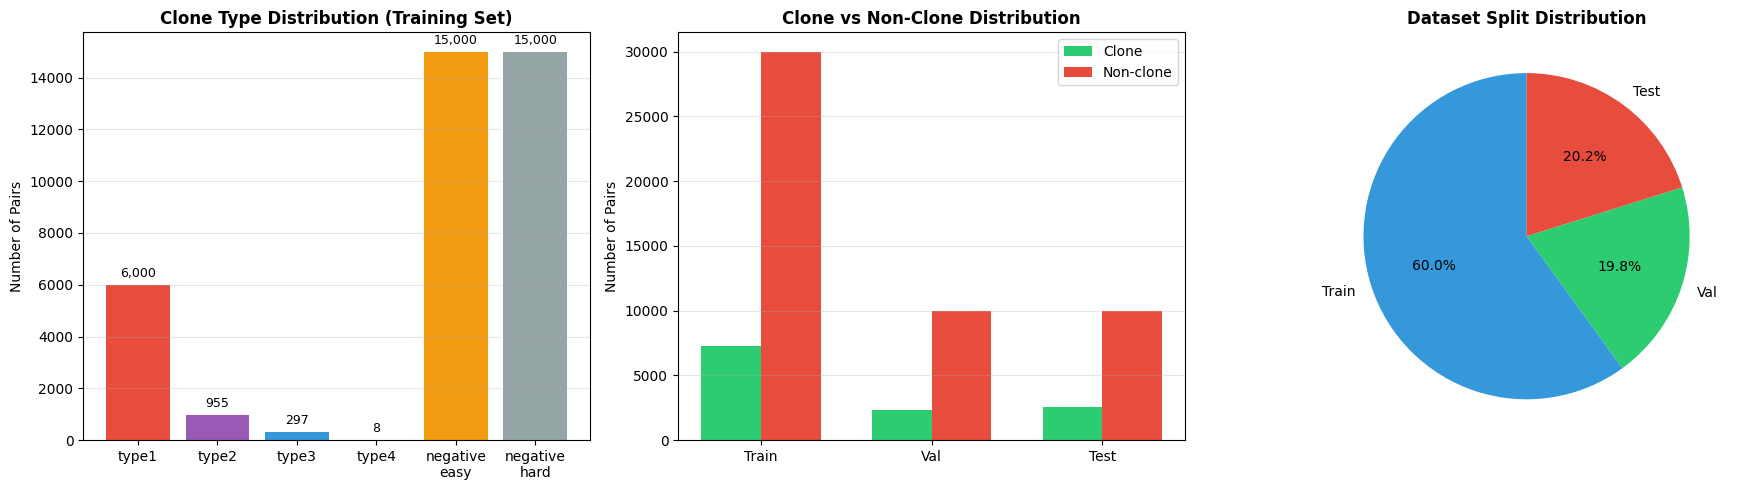


DATASET GENERATION COMPLETE!
Total pairs generated: 62,104
  Training:    37,260 pairs (60.0%)
  Validation:  12,323 pairs (19.8%)
  Test:        12,521 pairs (20.2%)


In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Clone Type Distribution (Train Set)
clone_types = list(stats['train']['types'].keys())
counts = [stats['train']['types'][t] for t in clone_types]
colors_bar = ['#e74c3c', '#9b59b6', '#3498db', '#2ecc71', '#f39c12', '#95a5a6']

axes[0].bar(range(len(clone_types)), counts, color=colors_bar[:len(clone_types)])
axes[0].set_xticks(range(len(clone_types)))
axes[0].set_xticklabels([t.replace('_', '\n') for t in clone_types], rotation=0)
axes[0].set_title('Clone Type Distribution (Training Set)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Pairs')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, count in enumerate(counts):
    axes[0].text(i, count + 200, f'{count:,}', ha='center', va='bottom', fontsize=9)

# 2. Label Distribution across all splits
splits = ['train', 'val', 'test']
clone_counts = [stats[split]['labels'].get(1, 0) for split in splits]
non_clone_counts = [stats[split]['labels'].get(0, 0) for split in splits]

x = np.arange(len(splits))
width = 0.35

axes[1].bar(x - width/2, clone_counts, width, label='Clone', color='#2ecc71')
axes[1].bar(x + width/2, non_clone_counts, width, label='Non-clone', color='#e74c3c')
axes[1].set_xticks(x)
axes[1].set_xticklabels([s.capitalize() for s in splits])
axes[1].set_title('Clone vs Non-Clone Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Pairs')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# 3. Dataset Split Sizes
splits = ['train', 'val', 'test']
sizes = [stats[split]['total'] for split in splits]
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Check if all sizes are non-zero before creating pie chart
if all(size > 0 for size in sizes):
    axes[2].pie(sizes, labels=[s.capitalize() for s in splits], autopct='%1.1f%%',
               colors=colors, startangle=90)
    axes[2].set_title('Dataset Split Distribution', fontsize=12, fontweight='bold')
else:
    axes[2].text(0.5, 0.5, 'Dataset splits not yet generated', 
                ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Dataset Split Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("DATASET GENERATION COMPLETE!")
print("="*80)
print(f"Total pairs generated: {sum(sizes):,}")
print(f"  Training:   {sizes[0]:>7,} pairs ({sizes[0]/sum(sizes)*100:.1f}%)")
print(f"  Validation: {sizes[1]:>7,} pairs ({sizes[1]/sum(sizes)*100:.1f}%)")
print(f"  Test:       {sizes[2]:>7,} pairs ({sizes[2]/sum(sizes)*100:.1f}%)")
print("="*80)

## Step 10: Load Sample Pairs for Inspection

Load and display a few actual code pairs to verify quality.

In [ ]:
def display_pair(pair, show_code=True):
    """Display a code pair with metadata."""
    print("\n" + "="*80)
    print(f"ID: {pair['id']}")
    print(f"Type: {pair['type']}")
    print(f"Label: {'Clone' if pair['label'] == 1 else 'Non-clone'}")
    print(f"Language: {pair['lang']}")
    print("="*80)
    
    if show_code:
        print("\nCODE 1:")
        print("-" * 80)
        print(pair['code1'][:500])  # Show first 500 chars
        if len(pair['code1']) > 500:
            print("... (truncated)")
        
        print("\nCODE 2:")
        print("-" * 80)
        print(pair['code2'][:500])  # Show first 500 chars
        if len(pair['code2']) > 500:
            print("... (truncated)")

# Load sample pairs from training set
train_file = dataset_files['train']
if train_file.exists():
    with jsonlines.open(train_file) as reader:
        train_samples = [pair for i, pair in enumerate(reader) if i < 100]  # Load first 100
    
    # Display one example of each type
    for clone_type in ['type1', 'type2', 'type3', 'type4']:
        matching = [p for p in train_samples if p['type'] == clone_type]
        if matching:
            print(f"\n\n{'='*80}")
            print(f"EXAMPLE: {clone_type.upper()}")
            print(f"{'='*80}")
            display_pair(matching[0], show_code=True)

## Summary

Congratulations! You have successfully generated a code clone detection dataset.

### Next Steps:

1. **Data Loading**: Create a PyTorch/TensorFlow DataLoader for your model
2. **Model Training**: Train your code clone detection model on the generated dataset
3. **Evaluation**: Use the validation set for hyperparameter tuning and test set for final evaluation
4. **Fine-tuning**: Adjust clone type ratios or target pairs and regenerate if needed

### Dataset Files Location:
- Training set: `train.jsonl`
- Validation set: `val.jsonl`
- Test set: `test.jsonl`

### Dataset Format:
Each line in the JSONL files contains:
```json
{
  "id": "unique_identifier",
  "code1": "first code snippet",
  "code2": "second code snippet",
  "label": 1 or 0 (1 = clone, 0 = non-clone),
  "type": "clone type or negative type",
  "lang": "programming language"
}
```

### References:
- Project CodeNet: https://github.com/IBM/Project_CodeNet
- Tree-sitter: https://tree-sitter.github.io/tree-sitter/

## Additional Testing & Validation

### Test Clone Generators with Real CodeNet Data

Before running the full dataset generation, let's test the clone generators with actual CodeNet submissions to ensure they work correctly.

In [ ]:
# Test with actual CodeNet submissions
import random
from pathlib import Path

# Select a random problem with sufficient submissions
test_problems = [p for p, langs in working_index.items() 
                 if any(len(subs) >= 2 for subs in langs.values())]

if test_problems:
    test_problem = random.choice(test_problems[:50])  # Pick from first 50
    print(f"Testing with problem: {test_problem}")
    
    # Get a language with multiple submissions
    test_lang = None
    test_submissions = []
    for lang, subs in working_index[test_problem].items():
        if len(subs) >= 2:
            test_lang = lang
            test_submissions = subs[:3]  # Get up to 3 submissions
            break
    
    if test_lang and test_submissions:
        print(f"Language: {test_lang}")
        print(f"Number of submissions available: {len(test_submissions)}")
        
        # Load first submission
        from scripts.clone_generators import _load_code_from_submission
        
        test_sub = test_submissions[0]
        test_code = _load_code_from_submission(CODENET_ROOT, test_problem, test_sub, test_lang)
        
        if test_code:
            print(f"\n✓ Successfully loaded code from submission: {test_sub}")
            print(f"  Code length: {len(test_code)} characters")
            print(f"  Lines: {len(test_code.splitlines())}")
            print(f"\n  First 200 characters:")
            print(f"  {test_code[:200]}...")
        else:
            print(f"\n✗ Failed to load code from submission: {test_sub}")
            print(f"  Check if file exists at: {Path(CODENET_ROOT) / 'data' / test_problem / test_lang / test_sub}")
    else:
        print("No suitable language/submissions found for testing")
else:
    print("No suitable problems found for testing")

### Test Type-1, Type-2, Type-3, and Type-4 with Real CodeNet Code

In [ ]:
if test_code and test_lang:
    print("="*80)
    print("TESTING ALL CLONE TYPES WITH REAL CODENET DATA")
    print("="*80)
    
    # Test Type-1: Comment removal and whitespace normalization
    print("\n1. Type-1 Clone Generation (Comment/Whitespace Normalization)")
    print("-"*80)
    try:
        type1_result = generate_type1(test_code, test_lang, parser)
        print(f"✓ Type-1 generation successful")
        print(f"  Original length: {len(test_code)} chars")
        print(f"  Normalized length: {len(type1_result)} chars")
        print(f"  Reduction: {(1 - len(type1_result)/len(test_code))*100:.1f}%")
        if type1_result:
            print(f"  First 150 chars: {type1_result[:150]}...")
    except Exception as e:
        print(f"✗ Type-1 generation failed: {e}")
    
    # Test Type-2: Identifier renaming
    print("\n2. Type-2 Clone Generation (Identifier Renaming)")
    print("-"*80)
    try:
        type2_result = generate_type2(test_code, test_lang, parser)
        print(f"✓ Type-2 generation successful")
        print(f"  Original length: {len(test_code)} chars")
        print(f"  Renamed length: {len(type2_result)} chars")
        print(f"  Changed: {type2_result != test_code}")
        if type2_result:
            print(f"  First 150 chars: {type2_result[:150]}...")
    except Exception as e:
        print(f"✗ Type-2 generation failed: {e}")
    
    # Test Type-3: Structural modifications
    print("\n3. Type-3 Clone Generation (Structural Modifications)")
    print("-"*80)
    try:
        type3_result = generate_type3(test_code, test_lang, use_llm=False, parser=parser)
        print(f"✓ Type-3 generation successful")
        print(f"  Original length: {len(test_code)} chars")
        print(f"  Modified length: {len(type3_result)} chars")
        print(f"  Changed: {type3_result != test_code}")
        if type3_result:
            print(f"  First 150 chars: {type3_result[:150]}...")
    except Exception as e:
        print(f"✗ Type-3 generation failed: {e}")
    
    # Test Type-4: Tokenization and similarity check
    print("\n4. Type-4 Clone Detection (Low Similarity, Same Problem)")
    print("-"*80)
    if len(test_submissions) >= 2:
        try:
            from scripts.clone_generators import _tokenize_code, _jaccard_similarity
            
            # Load two different submissions
            code1 = _load_code_from_submission(CODENET_ROOT, test_problem, test_submissions[0], test_lang)
            code2 = _load_code_from_submission(CODENET_ROOT, test_problem, test_submissions[1], test_lang)
            
            if code1 and code2:
                tokens1 = _tokenize_code(code1, test_lang, parser)
                tokens2 = _tokenize_code(code2, test_lang, parser)
                
                similarity = _jaccard_similarity(tokens1, tokens2)
                
                print(f"✓ Type-4 tokenization and similarity check successful")
                print(f"  Submission 1: {len(code1)} chars, {len(tokens1)} unique tokens")
                print(f"  Submission 2: {len(code2)} chars, {len(tokens2)} unique tokens")
                print(f"  Jaccard similarity: {similarity:.3f}")
                print(f"  Is Type-4 candidate (< 0.4): {similarity < 0.4}")
                
                if similarity < 0.4:
                    print(f"  ✓ These submissions qualify as Type-4 clones (low syntactic similarity)")
                else:
                    print(f"  ℹ These submissions are too similar for Type-4 (try other submission pairs)")
            else:
                print("✗ Could not load both submissions")
        except Exception as e:
            print(f"✗ Type-4 testing failed: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("  Not enough submissions to test Type-4")
    
    print("\n" + "="*80)
    print("All clone type tests completed!")
    print("="*80)
else:
    print("No test code available - please run the previous cell first")